In [2]:
library('igraph')
library('dplyr')
library('ggplot2')
library('ggmap')


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘dplyr’

The following objects are masked from ‘package:igraph’:

    as_data_frame, groups, union

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



<h2>Question 6</h2>

In [3]:
movement_graph <- read.table('../uber_data/movement_edgelist.txt')

In [4]:
g <- graph_from_data_frame(movement_graph, directed=FALSE)

In [5]:
E(g)$weight=as.numeric(movement_graph[,3])

In [6]:
is.connected(g)
writeLines(paste("Number of edges: ", ecount(g)))
writeLines(paste("Number of vertices: ", vcount(g)))
writeLines(paste("Diameter: ", diameter(g)))
#plot(g, vertex.label=NA, vertex.size=3)

[1] FALSE

Number of edges:  311812
Number of vertices:  1887
Diameter:  11911.84


In [7]:
dg <- decompose.graph(g)      
gcc_index <- which.max(sapply(dg,vcount))
gcc <- dg[[gcc_index]] 
clusters <- components(gcc)
#print(dim(groups(clusters)))
writeLines(paste("Number of edges: ", ecount(gcc)))
writeLines(paste("Number of vertices: ", vcount(gcc)))
writeLines(paste("Diameter of GCC: ", diameter(gcc)))

Number of edges:  311802
Number of vertices:  1880
Diameter of GCC:  11911.84


In [8]:
geo_data <- read.table('../uber_data/geo_data.csv', sep=',', header=TRUE)

In [9]:
#print(which(name_sectors_colors$Symbol == 'ZTS'))
print(geo_data[which(geo_data$movement_id == '1'),1])

[1] Sargent Creek, San Ardo
2704 Levels: 0 12th East Street, Pittsburg ...


In [10]:
v = 1
which(V(gcc)$name == v)

integer(0)

In [11]:
v = 6
print(v)
gcc <- set_vertex_attr(gcc, "location", index=which(V(gcc)$name == v), as.character(geo_data[which(geo_data$movement_id == v), 2]))
gcc <- set_vertex_attr(gcc, "display_name", index=which(V(gcc)$name == v), as.character(geo_data[which(geo_data$movement_id == v), 1]))

[1] 6


In [12]:
geo_data[which(geo_data$movement_id == v), 1]

[1] 100 Carlsbad Circle, Vacaville
2704 Levels: 0 12th East Street, Pittsburg ...

In [13]:
vertex_attr(gcc, index=1)

$name
[1] "6"

$location
[1] "[-121.94843241   38.36665327]"

$display_name
[1] "100 Carlsbad Circle, Vacaville"

In [14]:
for (v in V(gcc)$name) {
    gcc <- set_vertex_attr(gcc, "location", index=which(V(gcc)$name == v), 
                           as.character(geo_data[which(geo_data$movement_id == v), 2]))
    gcc <- set_vertex_attr(gcc, "display_name", index=which(V(gcc)$name == v), 
                           as.character(geo_data[which(geo_data$movement_id == v), 1]))
}

In [15]:
all_info <- cbind(vertex_attr(gcc)$name, vertex_attr(gcc)$location, vertex_attr(gcc)$display_name)

In [16]:
write.csv(data.frame(all_info), "../uber_data/GCC_nodes.csv")

<h2>Question 7</h2>

In [17]:
g_mst <- mst(gcc, algorithm="prim")

In [18]:
is.connected(g_mst)
writeLines(paste("Number of edges: ", ecount(g_mst)))
writeLines(paste("Number of vertices: ", vcount(g_mst)))
writeLines(paste("Diameter: ", diameter(g_mst)))
#plot(g, vertex.label=NA, vertex.size=3)

[1] TRUE

Number of edges:  1879
Number of vertices:  1880
Diameter:  45542.45


In [19]:
E(g_mst)

+ 1879/1879 edges from ed55ece (vertex names):
 [1] 7  --25  20 --79  43 --101 55 --102 57 --102 64 --104 62 --105 13 --111
 [9] 138--8   93 --150 123--153 43 --191 63 --219 198--223 178--224 230--115
[17] 39 --253 141--254 252--274 171--282 216--290 74 --300 143--301 78 --302
[25] 303--304 251--309 210--311 274--312 286--323 221--328 199--331 329--331
[33] 41 --334 91 --338 315--338 309--349 6  --366 275--370 253--372 369--372
[41] 325--382 333--389 175--396 371--397 270--400 40 --401 242--403 89 --420
[49] 30 --422 291--423 59 --435 134--437 80 --445 113--445 288--447 58 --456
[57] 283--456 98 --458 321--458 167--466 333--468 290--470 393--470 103--472
[65] 104--472 218--473 382--473 385--477 225--480 485--486 416--488 188--505
[73] 516--517 339--530 394--530 299--532 434--536 113--537 233--543 542--543
+ ... omitted several edges

In [20]:
vertex_attr(g_mst, index=which(V(g_mst)$name == 7))

$name
[1] "7"

$location
[1] "[-121.99610391   38.32584685]"

$display_name
[1] "Unnamed Road, Vacaville"

In [21]:
vertex_attr(g_mst, index=which(V(g_mst)$name == 25))

$name
[1] "25"

$location
[1] "[-121.9796351    38.34320795]"

$display_name
[1] "400 Bowline Drive, Vacaville"

<h2>Question 8</h2>

In [22]:
#graph_triangles = cliques(g, min=3,max=3)
graph_triangles = as.vector(triangles(gcc))

In [23]:
length(graph_triangles)/3

[1] 31678905

In [24]:
set.seed(0)
sample_ids = sample(length(graph_triangles)/3, 1000)

In [25]:
check_triangular_inequality <- function(w1, w2, w3) {
    if (((w1 + w2) > w3) & ((w1 + w3) > w2) & ((w3 + w2) > w1)) {
        return (1)
    } else {
        return (0)
    }
}

In [26]:
triads = c()
for (s in sample_ids) {
    #print(i)
    i = s*3 + 1
    u = (graph_triangles[[i]])
    v = (graph_triangles[[i+1]])
    w = (graph_triangles[[i+2]])
    
    e1 <- get.edge.ids(gcc, vp=c(u,v))
    e2 <- get.edge.ids(gcc, vp=c(v,w))
    e3 <- get.edge.ids(gcc, vp=c(u,w))
    #ei <- get.edge.ids(gcc, vp=lapply(c(u, v, v, w, u, w), get_name))
    w1 = edge_attr(gcc, "weight", index=e1)
    w2 = edge_attr(gcc, "weight", index=e2)
    w3 = edge_attr(gcc, "weight", index=e3)
    #print(c(u,v,w))
    triads = c(triads, check_triangular_inequality(w1, w2, w3))
}

In [27]:
tri_eq = sum(triads)/length(triads)

In [28]:
length(triads)

[1] 1000

In [29]:
writeLines(paste("Percentage of triangles satisfying triangular inequality: ", tri_eq))

Percentage of triangles satisfying triangular inequality:  0.929


<h2>Question 9</h2>

In [30]:
mst_vertices <- as.vector(V(g_mst))

In [31]:
V(g_mst)

+ 1880/1880 vertices, named, from ed55ece:
   [1] 6    7    9    11   13   17   20   21   23   24   25   27   28   30  
  [15] 31   38   39   40   41   42   43   44   46   47   48   55   56   57  
  [29] 58   59   60   61   62   63   64   65   66   69   73   74   75   76  
  [43] 77   78   79   80   81   82   83   86   87   88   89   90   91   92  
  [57] 93   94   96   97   98   99   100  101  102  103  104  105  107  108 
  [71] 109  111  113  116  117  118  119  123  125  126  127  128  131  132 
  [85] 133  134  136  137  138  141  142  143  146  150  151  152  153  154 
  [99] 155  156  157  158  159  160  165  167  168  169  170  171  172  173 
 [113] 174  175  176  178  179  181  182  184  186  187  188  191  193  194 
 [127] 195  196  198  199  204  206  207  208  209  210  211  212  215  216 
+ ... omitted several vertices

In [32]:
mst_vertices[[1]]

[1] 1

In [33]:
set.seed(0)
root_node <- sample(mst_vertices, 1)
#root_node <- mst_vertices[[1]]
root_node

[1] 1686

In [34]:
preorder <- dfs(g_mst, root_node)

In [35]:
preorder

$root
[1] 1685

$neimode
[1] "out"

$order
+ 1880/1880 vertices, named, from ed55ece:
   [1] 2458 1955 2504 1456 410  1452 1451 409  1450 1732 677  541  1438 676 
  [15] 1739 2451 311  210  1273 858  659  2318 1265 652  1271 1705 965  78  
  [29] 302  2343 2629 1780 2466 1944 44   2643 209  2465 1730 1449 2497 2673
  [43] 1781 82   1704 2316 651  208  1698 1281 1706 2442 908  1299 2443 1703
  [57] 650  206  2315 629  2622 1629 2319 1272 653  1639 2498 1783 665  2320
  [71] 675  1951 2625 1630 1646 1707 1702 2317 1282 207  1700 1699 648  2496
  [85] 1696 443  647  2601 646  1300 2321 1648 1278 1280 1682 113  445  80  
  [99] 867  2313 1276 536  434  643  9    1674 644  1691 1245 963  2340 1692
 [113] 1279 1694 2308 1695 1246 20   79   905  1688 1244 642  212  1686 1689
 [127] 1690 1257 165  641  452  866  1687 533  2460 906  1247 21   964  2606
+ ... omitted several vertices

$order.out
NULL

$father
NULL

$dist
NULL


In [36]:
order <- c(as.vector(preorder$order))

In [37]:
edge_ids <- c()
vertex_ids <- c()

In [38]:
get_shortest_distance <- function(gcc, order) {
    u = order[[1]]
    v = order[[length(order)]]
    cost = c()
    #print(length(unlist(order)))
    if (length(unlist(order)) == 2) {
        e = get.edge.ids(gcc, vp=c(u,v))
        w = edge_attr(gcc, "weight", index=e)
        cost = c(cost, w)
        edge_ids <<- c(edge_ids, e)
        vertex_ids <<- c(vertex_ids, u, v)
    }
    else {
        f = order[[2]]
        e = get.edge.ids(gcc, vp=c(u,f))
        w = edge_attr(gcc, "weight", index=e)
        if (length(w) == 0) {
            w = get_shortest_distance(gcc, vpath, u, f)
        }
        cost = c(cost, w)
        edge_ids <<- c(edge_ids, e)
        vertex_ids <<- c(vertex_ids, u, f)
        for (i in seq(from=2, to=length(order)-1, by=1)) {
            f = order[[i]]
            s = order[[i+1]]
            e = get.edge.ids(gcc, vp=c(f,s))
            w = edge_attr(gcc, "weight", index=e)
            if (length(w) == 0) {
                w = get_shortest_distance(gcc, vpath, f, s)
            }
            cost = c(cost, w) 
            edge_ids <<- c(edge_ids, e)
            vertex_ids <<- c(vertex_ids, f, s)
        }    
    }
    #print(edge_ids)
    return (sum(cost))
}

In [39]:
get_TSP_cost <- function(g_mst, order, root, gcc) {
    cost = c()
    for (i in seq(from=1, to=length(order)-1, by=1)) {
        #print(i)
        u = order[[i]]
        v = order[[i+1]]
       
        e = get.edge.ids(g_mst, vp=c(u,v))
        w = edge_attr(g_mst, "weight", index=e)
        
        if (length(w) == 0) {
            #print(c(u, v))
            vpath = as.vector(get.shortest.paths(gcc, u, v)$vpath[[1]])
            w = get_shortest_distance(gcc, vpath)
        }
        cost = c(cost, w)
        edge_ids <<- c(edge_ids, e)
        vertex_ids <<- c(vertex_ids, u, v)
    }
    u = order[[length(order)]]
    v = order[[root]]
    e = get.edge.ids(g_mst, vp=c(u,v))
    w = edge_attr(g_mst, "weight", index=e)
    if (length(w) == 0) {
        #print(c(u, v))
        vpath = as.vector(get.shortest.paths(gcc, u, v)$vpath[[1]])
        w = get_shortest_distance(gcc, vpath)
    }
    cost = c(cost, w)
    edge_ids <<- c(edge_ids, e)
    vertex_ids <<- c(vertex_ids, u, v)
    return (sum(cost))
}

In [40]:
cost = (get_TSP_cost(g_mst, order, root_node, gcc))

In [41]:
cost

[1] 437929.1

In [42]:
print(length(edge_ids))
print(length(vertex_ids))

[1] 2809
[1] 5618


In [43]:
optimal_cost = sum(edge_attr(g_mst, "weight"))
optimal_cost

[1] 279408.2

In [44]:
cost/optimal_cost

[1] 1.567345

In [45]:
2809*2

[1] 5618

<h2>Question 10</h2>

In [46]:
edges = edge_ids[edge_ids > 0]
length(edges)

[1] 2316

In [47]:
location_ids <- vertex_attr(gcc, index=unique(vertex_ids))$location

In [48]:
coordinates_x <- c()
coordinates_y <- c()
for (loc in location_ids) {
    coord <- as.numeric(unlist(regmatches(loc, gregexpr(".[0-9]*[.][0-9]*", loc))))
    coordinates_x <- c(coordinates_x, coord[[1]])
    coordinates_y <- c(coordinates_y, coord[[2]])
}

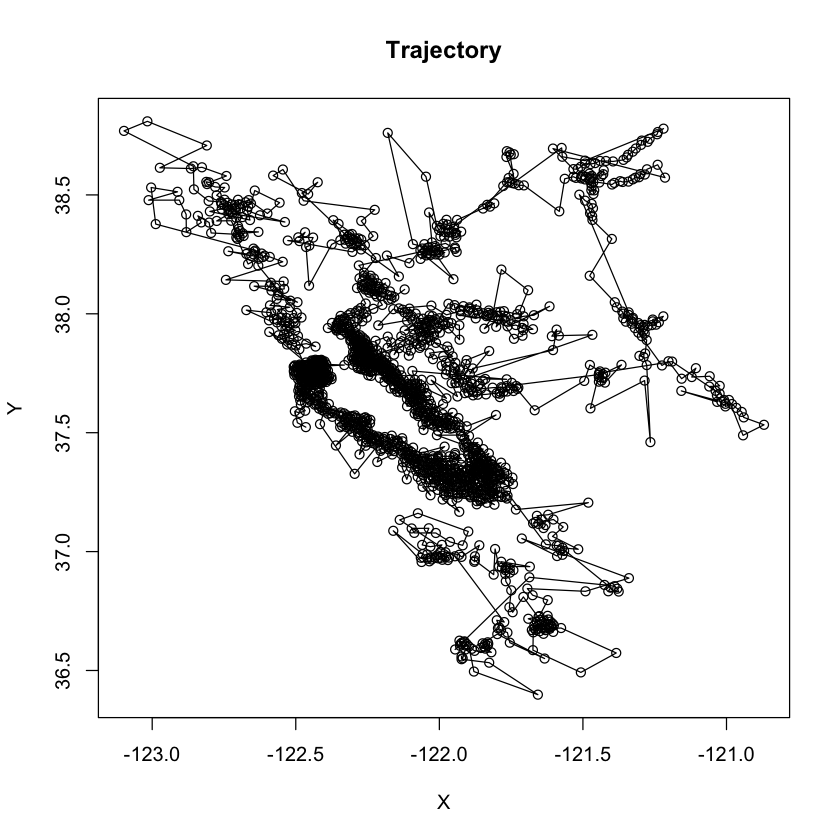

In [49]:
plot(coordinates_x, coordinates_y, type="o", xlab="X", ylab="Y", main="Trajectory")

<h2>Question 11</h2>

In [110]:
denaulay_edges <- read.table("../uber_data/Denaulay_Edges.csv", sep=",", header=FALSE)

In [111]:
#denaulay <- graph_from_data_frame(denaulay_edges, directed=FALSE)

In [179]:
names_src = names_dest = vertex_attr(gcc, "name", index=V(gcc)[[denaulay_edges[[1]]]])
names_dest = vertex_attr(gcc, "name", index=V(gcc)[[denaulay_edges[[2]]]])

In [182]:
denaulay <- graph_from_data_frame(as.data.frame(cbind(names_src, names_dest)), directed=FALSE)
#as.data.frame(cbind(names_src, names_dest))

In [183]:
denaulay

IGRAPH 801e511 UN-- 1880 11244 -- 
+ attr: name (v/c)
+ edges from 801e511 (vertex names):
 [1] 2073--806  2073--1177 806 --1177 1444--2017 1444--583  2017--583 
 [7] 1177--2383 1177--583  2383--583  2478--1171 2478--1955 1171--1955
[13] 2327--1442 2327--342  1442--342  2383--1442 2383--2327 2327--1442
[19] 38  --1965 1444--38   1444--1965 2073--577  2073--806  806 --577 
[25] 896 --1162 2017--896  2017--1162 2112--2241 1171--2112 1171--2241
[31] 1763--2458 1763--1955 2458--1955 1720--2504 1720--1732 2504--1732
[37] 234 --2629 234 --1447 2629--1447 800 --2005 806 --800  806 --2005
[43] 800 --2005 2005--1995 800 --1995 2005--587  806 --2005 806 --587 
+ ... omitted several edges

In [184]:
E(denaulay)

+ 11244/11244 edges from 801e511 (vertex names):
 [1] 2073--806  2073--1177 806 --1177 1444--2017 1444--583  2017--583 
 [7] 1177--2383 1177--583  2383--583  2478--1171 2478--1955 1171--1955
[13] 2327--1442 2327--342  1442--342  2383--1442 2383--2327 2327--1442
[19] 38  --1965 1444--38   1444--1965 2073--577  2073--806  806 --577 
[25] 896 --1162 2017--896  2017--1162 2112--2241 1171--2112 1171--2241
[31] 1763--2458 1763--1955 2458--1955 1720--2504 1720--1732 2504--1732
[37] 234 --2629 234 --1447 2629--1447 800 --2005 806 --800  806 --2005
[43] 800 --2005 2005--1995 800 --1995 2005--587  806 --2005 806 --587 
[49] 577 --2026 806 --577  806 --2026 1965--2364 1444--1965 1444--2364
[55] 2364--344  1965--344  1965--2364 896 --2586 2017--2586 2017--896 
+ ... omitted several edges

In [188]:
for (v in V(denaulay)$name) {
    denaulay <- set_vertex_attr(denaulay, "location", index=which(V(denaulay)$name == v), 
                           as.character(geo_data[which(geo_data$movement_id == v), 2]))
    denaulay <- set_vertex_attr(denaulay, "display_name", index=which(V(denaulay)$name == v), 
                           as.character(geo_data[which(geo_data$movement_id == v), 1]))
}

In [189]:
unlist(E(denaulay))

+ 11244/11244 edges from 801e511 (vertex names):
 [1] 2073--806  2073--1177 806 --1177 1444--2017 1444--583  2017--583 
 [7] 1177--2383 1177--583  2383--583  2478--1171 2478--1955 1171--1955
[13] 2327--1442 2327--342  1442--342  2383--1442 2383--2327 2327--1442
[19] 38  --1965 1444--38   1444--1965 2073--577  2073--806  806 --577 
[25] 896 --1162 2017--896  2017--1162 2112--2241 1171--2112 1171--2241
[31] 1763--2458 1763--1955 2458--1955 1720--2504 1720--1732 2504--1732
[37] 234 --2629 234 --1447 2629--1447 800 --2005 806 --800  806 --2005
[43] 800 --2005 2005--1995 800 --1995 2005--587  806 --2005 806 --587 
[49] 577 --2026 806 --577  806 --2026 1965--2364 1444--1965 1444--2364
[55] 2364--344  1965--344  1965--2364 896 --2586 2017--2586 2017--896 
+ ... omitted several edges

In [190]:
is.simple(denaulay)

[1] FALSE

In [191]:
denaulay <- simplify(denaulay, remove.multiple = TRUE, remove.loops = FALSE)

In [192]:
is.simple(denaulay)

[1] TRUE

In [193]:
is.connected(denaulay)
writeLines(paste("Number of edges: ", ecount(denaulay)))
writeLines(paste("Number of vertices: ", vcount(denaulay)))
writeLines(paste("Diameter: ", diameter(denaulay)))
#plot(g, vertex.label=NA, vertex.size=3)

[1] TRUE

Number of edges:  5627
Number of vertices:  1880
Diameter:  25


In [119]:
get_id <- function(x) {
    return (which(V(gcc)$name == x))
}

In [120]:
which(as.vector(V(gcc)) == 1422)

[1] 1422

In [205]:
travel_times <- c()
source_list <- c()
dest_list <- c()
source_loc <- c()
dest_loc <- c()
for (e in E(denaulay)) {
    source <- ends(denaulay, e)[1]
    destination <- ends(denaulay, e)[2]
    u = as.numeric(get_id(source))
    v = as.numeric(get_id(destination))
    if (are.connected(gcc, u, v)) { 
        e_id = get.edge.ids(gcc, vp=c(u,v))
        w = edge_attr(gcc, "weight", index=e_id)
        travel_times <- c(travel_times, w)
    }
    else {
        vpath = as.vector(get.shortest.paths(gcc, u, v)$vpath[[1]])
        w = get_shortest_distance(gcc, vpath)
        travel_times <- c(travel_times, w)
    }
    ed = get.edge.ids(denaulay, vp=c(u,v))
    denaulay <- set_edge_attr(denaulay, "weight", index=ed, value=w)
    source_list <- c(source_list, source)
    dest_list <- c(dest_list, destination)
    source_loc <- c(source_loc, vertex_attr(denaulay, "location", index=(which(V(denaulay)$name == source))))
    dest_loc <- c(dest_loc, vertex_attr(denaulay, "location", index=(which(V(denaulay)$name == destination))))
}

In [206]:
travel_flow_data <- cbind(source_list, dest_list, source_loc, dest_loc, travel_times)

In [207]:
write.csv(data.frame(travel_flow_data), "../uber_data/Travel_Flow_Data.csv")

<h2>Question 13</h2>

In [208]:
print(which(geo_data[[1]] == "100 Campus Drive, Stanford"))
print(which(geo_data[[1]] == "700 Meder Street, Santa Cruz"))

[1] 2607
[1] 1968


In [209]:
geo_data[2607, ]
geo_data[1968, ]

,display_name,location,movement_id
2607,"100 Campus Drive, Stanford",[-122.17598222 37.42968589],2607


,display_name,location,movement_id
1968,"700 Meder Street, Santa Cruz",[-122.06456181 36.97416881],1968


In [210]:
src = as.numeric(get_id(2607))
target = as.numeric(get_id(1968))

In [211]:
travel <- read.table("../uber_data/TravelFlow.csv", sep=",", header=FALSE)

In [213]:
E(denaulay)$capacity <- travel[[9]]*2

In [214]:
denaulay

IGRAPH 551b9a6 UNW- 1880 5627 -- 
+ attr: name (v/c), location (v/c), display_name (v/c), weight (e/n),
| capacity (e/n)
+ edges from 551b9a6 (vertex names):
 [1] 2073--806  2073--1177 2073--577  2073--777  2073--1313 806 --1177
 [7] 806 --577  806 --800  806 --2005 806 --587  806 --2026 806 --1999
[13] 806 --1192 1444--2017 1444--38   1444--1965 1444--2364 1444--793 
[19] 1444--1988 1444--1445 1444--1231 1444--406  1444--583  2017--896 
[25] 2017--1162 2017--2586 2017--1988 2017--583  1177--2383 1177--1410
[31] 1177--1371 1177--1999 1177--1194 1177--13   1177--583  2383--2327
[37] 2383--1442 2383--1410 2383--1412 2383--2076 2383--374  2383--1418
+ ... omitted several edges

In [215]:
max_flow(denaulay, src, target, travel[[9]]*2)

$value
[1] 13600.45

$flow
   [1]     0.00000     0.00000     0.00000     0.00000     0.00000     0.00000
   [7]     0.00000     0.00000     0.00000     0.00000     0.00000     0.00000
  [13]     0.00000     0.00000     0.00000     0.00000     0.00000     0.00000
  [19]     0.00000     0.00000     0.00000     0.00000     0.00000     0.00000
  [25]     0.00000     0.00000     0.00000     0.00000     0.00000     0.00000
  [31]     0.00000     0.00000     0.00000     0.00000     0.00000     0.00000
  [37]     0.00000     0.00000     0.00000     0.00000     0.00000     0.00000
  [43]     0.00000     0.00000     0.00000  2049.23997 -2049.23997     0.00000
  [49]     0.00000     0.00000     0.00000     0.00000     0.00000     0.00000
  [55]  2049.23997     0.00000     0.00000     0.00000     0.00000     0.00000
  [61]     0.00000     0.00000     0.00000     0.00000     0.00000     0.00000
  [67]     0.00000     0.00000     0.00000     0.00000     0.00000     0.00000
  [73]     0.00000     0.

In [216]:
edge_disjoint_paths(denaulay, src, target)

[1] 5

<h2>Question 14</h2>

In [63]:
den_location_ids <- vertex_attr(denaulay, index=V(denaulay))$location

In [64]:
coordinates_lat <- c()
coordinates_long <- c()
for (loc in den_location_ids) {
    coord <- as.numeric(unlist(regmatches(loc, gregexpr(".[0-9]*[.][0-9]*", loc))))
    coordinates_lat <- c(coordinates_lat, coord[[2]])
    coordinates_long <- c(coordinates_long, coord[[1]])
}

In [65]:
coordinates <- as.data.frame(cbind(coordinates_long,coordinates_lat))
#df

In [66]:
print(mean(coordinates$coordinates_long))
print(mean(coordinates$coordinates_lat))

[1] -121.8505
[1] 37.94167


In [67]:
map <- get_map(location = c(lon = mean(coordinates$coordinates_long), lat = mean(coordinates$coordinates_lat)), 
               zoom = 7, scale = 2, maptype = c("roadmap"))

Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=37.941674,-121.850507&zoom=7&size=640x640&scale=2&maptype=roadmap&language=en-EN&sensor=false


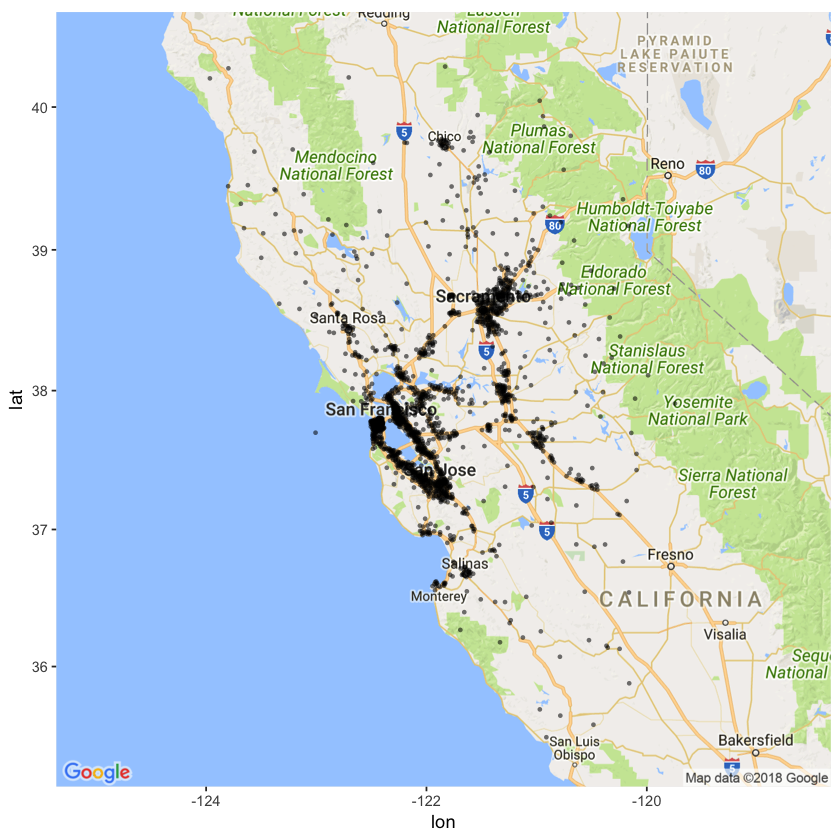

In [68]:
# plotting the map with some points on it
ggmap(map) +
  geom_point(data = coordinates, aes(x = coordinates_long, y = coordinates_lat, fill = "red", alpha = 0.8), 
             size = 1, shape = 16) +
  guides(fill=FALSE, alpha=FALSE, size=FALSE)

In [69]:
bridges <- c()

<h2>Question 15</h2>